This code explains the process of using pretrained weights (VGG16) 
as feature extractors for both neural network and 
traditional machine learning (Random Forest). 
It also uses dimensional reduction using PCA to reduce the number of features for
speedy training. 
"""

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:

import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers import LayerNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16


## Load images

In [ ]:
# Read input images and assign labels based on folder names
data_path="/content/drive/MyDrive/Traffic_Dataset/traffic_data"

import pathlib
data_dir = pathlib.Path(data_path)

files_count=len(os.listdir(data_dir))
print(files_count)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

7
357


### Read images while using loop then resize them. Convert list into arrays and extract labels from text to integer by using sklearn preprocessing

In [ ]:

# Read input images and assign labels based on folder names
print(os.listdir("/content/drive/MyDrive/Traffic_Dataset/traffic_data"))

SIZE = 256  #Resize images

#Capture training data and labels into respective lists
data_images = []
data_labels = [] 

for directory_path in glob.glob("/content/drive/MyDrive/Traffic_Dataset/traffic_data/*"):
    label = directory_path.split("\\")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        data_images.append(img)
        data_labels.append(label)

#Convert lists to arrays        
data_images = np.array(data_images)
data_labels = np.array(data_labels)



#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data_labels)
data_labels_encoded = le.transform(data_labels)


type(data_labels_encoded)


['Speed Limit', 'Object Marker', 'Stop', 'Do Not Enter', 'Information', 'School', 'Left_Turn']


numpy.ndarray

## Train Test Split dataset

In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_images, data_labels_encoded, test_size=0.2, random_state=42)



In [ ]:
x_train.shape

(285, 256, 256, 3)

## Scaling Feautres

In [ ]:
# Scale pixel values to between 0 and 1
x_train= x_train / 255.0
x_test=x_test/255.0

#One hot encode y values for neural network. Not needed for Random Forest
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## Load VGG model with trained weights

In [ ]:
#Load VGG model with imagenet trained weights and without classifier/fully connected layers
#We will use this as feature extractor. 
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
#Now, let us extract features using VGG imagenet weights
#Train features
train_feature_extractor=VGG_model.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
#test features
test_feature_extractor=VGG_model.predict(x_test)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

## Using PCA to reduce dimensions

Text(0, 0.5, 'Cum variance')

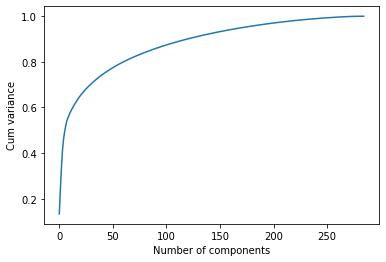

In [ ]:

# Reduce dimensions using PCA
from sklearn.decomposition import PCA

#First verfiy the ideal number of PCA components to not lose much information. 
#Try to retain 90% information, so look where the curve starts to flatten.
#Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=285) 
pca_test.fit(train_features)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

This plot shows that maximum number of PCA components are more than 285 but our rows are limit to 285 we can pick this value. On this value we have acheived highest cum variance almost equals to 1


Extract train and test PCA Features from PCA analysis then fit and transform train and test data to gain train and test features

In [ ]:
#Pick the optimal number of components. This is how many features we will have 
#for our machine learning
n_PCA_components = 285
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features) #Make sure you are just transforming, not fitting. 


## Train data into the model

In [ ]:
#If we want 90% information captured we can also try ...
#pca=PCA(0.9)
#principalComponents = pca.fit_transform(X_for_RF)

############## Neural Network Approach ##################

##Add hidden dense layers and final output/classifier layer.
model = Sequential()
inputs = Input(shape=(n_PCA_components,)) #Shape = n_components
hidden = Dense(256, activation='relu')(inputs)
#hidden1 = Dense(512, activation='relu')(inputs)
#hidden2 = Dense(256, activation='relu')(hidden1)
output = Dense(7, activation='softmax')(hidden)
model = Model(inputs=inputs, outputs=output)


print(model.summary())
#
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 285)]             0         
                                                                 
 dense_10 (Dense)            (None, 256)               73216     
                                                                 
 dense_11 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 75,015
Trainable params: 75,015
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import datetime
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
model.fit(train_PCA, y_train_one_hot, epochs=20, verbose=1)

end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)


Epoch 1/20
9/9 [==============================] - 0s 5ms/step - loss: 5.3452e-06 - categorical_accuracy: 1.0000
Epoch 2/20
9/9 [==============================] - 0s 4ms/step - loss: 3.3140e-06 - categorical_accuracy: 1.0000
Epoch 3/20
9/9 [==============================] - 0s 5ms/step - loss: 2.0575e-06 - categorical_accuracy: 1.0000
Epoch 4/20
9/9 [==============================] - 0s 4ms/step - loss: 1.2858e-06 - categorical_accuracy: 1.0000
Epoch 5/20
9/9 [==============================] - 0s 4ms/step - loss: 8.0519e-07 - categorical_accuracy: 1.0000
Epoch 6/20
9/9 [==============================] - 0s 4ms/step - loss: 4.9942e-07 - categorical_accuracy: 1.0000
Epoch 7/20
9/9 [==============================] - 0s 4ms/step - loss: 3.2166e-07 - categorical_accuracy: 1.0000
Epoch 8/20
9/9 [==============================] - 0s 4ms/step - loss: 1.9408e-07 - categorical_accuracy: 1.0000
Epoch 9/20
9/9 [==============================] - 0s 4ms/step - loss: 1.2339e-07 - categorical_accuracy:

## Now, predict our Test data by using model

In [ ]:
##Predict on test dataset
predict_test = model.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
# predict_test = le.inverse_transform(predict_test)


### Find overall accuracy by comparing actual and predict outputs

In [ ]:
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, predict_test))


Accuracy =  1.0


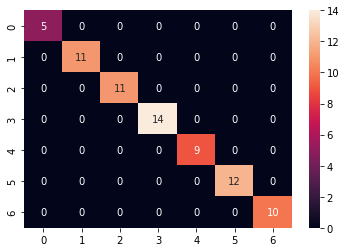

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict_test)
#print(cm)
sns.heatmap(cm, annot=True)


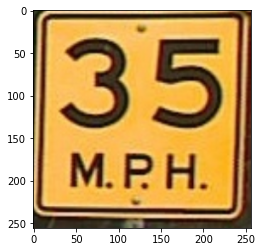

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)

## Check on image to classify it label

In [ ]:

input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
input_img_PCA = pca.transform(input_img_features)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
print("The actual label for this image is: ", y_test[n])


The prediction for this image is:  ['/content/drive/MyDrive/Traffic_Dataset/traffic_data/Speed Limit']
The actual label for this image is:  5


Accuracy =  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


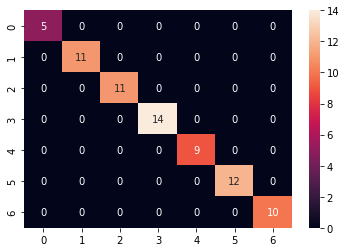

In [ ]:
#RANDOM FOREST implementation (Uncomment to run this part)
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 80, random_state = 42)
# Train the model on training data
RF_model.fit(train_PCA, y_train) #For sklearn no one hot encoding
#Send test data through same feature extractor process
#X_test_feature = VGG_model.predict(x_test)
#X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(test_PCA)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
# cmm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)
